In [0]:
import numpy as np
import scipy.sparse as sp
import math
import pickle
import matplotlib.pyplot as plt

In [0]:
class Node:
    def __init__(self,indices,depth):
        self.indices = indices #contains all the index for of datax and datay to be processes by the node 
        self.attribute = None #at what attribute (best) we splitted (if not leaf)
        self.left = None #list of all the children nodes at which we splitted this
        self.right = None
        self.aval = None #label assigned to the node (if leaf)
        self.depth = depth #depth at each node
        self.label = None
        self.below = None
        self.itself = None
        return

    def add_child(self,li,ri,attribute,aval,label):
        self.left = Node(li,self.depth+1)
        self.right = Node(ri,self.depth+1)
        self.attribute = attribute
        self.aval = aval
        self.label = label
        return
    
    def add_label(self,label):
        self.label = label
        return

  

In [0]:
def get_entropy(datay):
    countpos = np.sum(datay)
    countneg = datay.size - countpos
    p0 = (countneg * 1.0) / (countneg + countpos)
    p1 = 1.0 - p0
    try:
        val = ((p0 * math.log(p0, 2)) + (p1 * math.log(p1, 2)))
    except:
        val = 0.0 #takes the value 0 in the limiting case
    return (-1.0 * val)

In [0]:
def cond_entropy(data):
    med = np.median(data[:,0])
    l = data[data[:,0]<=med]
    r = data[data[:,0]>med]
    pl = float(len(l))/(len(l)+len(r))
    pr = 1.-pl
    if (len(l)>0 and len(r)>0):
        ce = pl*get_entropy(l[:,1])+pr*get_entropy(r[:,1])
    else:
        ce = math.inf
    return ce,med,l[:,2],r[:,2]

In [0]:
def choose_best_feature(indices):
    data = train[indices,482]
    h = get_entropy(data)
    p1 = np.sum(data)
    label = 0
    if p1*2 > len(data):
        label = 1
    in_data = np.zeros((len(data),3),dtype = 'int')
    in_data[:,0] = train[indices,0]
    in_data[:,1] = train[indices,482]
    in_data[:,2] = train[indices,483]
    ce,med,li,ri = cond_entropy(in_data)
    mi = h - ce
    index = 0
    for i in range(1,482):
        in_data[:,0] = train[indices,i]
        ce_temp,med_temp,li_temp,ri_temp = cond_entropy(in_data)
        mi_temp = h - ce_temp
        if mi<mi_temp:
            mi = mi_temp
            index= i
            li = li_temp
            ri = ri_temp
            med = med_temp
    return mi,index,med,li,ri,label

In [0]:
def generate_tree(node):
    global num_nodes
    global h_depth

    num_nodes += 1
    if node.depth > h_depth:
        h_depth = node.depth 
    mi,att,med,l,r,label = choose_best_feature(node.indices)    
    if len(l>0) and len(r)>0 and mi>0:
        node.add_child(l,r,att,med,label)
    else: 
        node.add_label(label)
    if node.left != None:
        generate_tree(node.left)
    if node.right != None:
        generate_tree(node.right)
    return

In [0]:
pickle_in = open("/content/drive/My Drive/train.pk","rb")
trainx = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/content/drive/My Drive/test.pk","rb")
testx = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/content/drive/My Drive/valid.pk","rb")
validx = pickle.load(pickle_in)
pickle_in.close()

In [11]:
# Read file with y data
trainy = []
testy = []
validy = []

with open('/content/drive/My Drive/train_y.txt') as fy:
    for line in fy:
        trainy.append(float(line))
trainy = np.array(trainy,dtype = 'int')
# print(trainy.shape)

with open('/content/drive/My Drive/test_y.txt') as fy:
    for line in fy:
        testy.append(float(line))
testy = np.array(testy,dtype = 'int')
# print(testy.shape)

with open('/content/drive/My Drive/valid_y.txt') as fy:
    for line in fy:
        validy.append(float(line))
validy = np.array(validy,dtype = 'int')
# print(validy.shape)

row_train,col_train = trainx.shape
train = np.zeros((row_train,col_train+2),dtype = 'int')
train[:,:col_train] = np.array(trainx,dtype = 'int')
train[:,col_train] = trainy
train[:,col_train+1] = np.arange(row_train)

row_valid,col_valid = validx.shape
valid = np.zeros((row_valid,col_valid+2),dtype = 'int')
valid[:,:col_valid] = np.array(validx,dtype = 'int')
valid[:,col_valid] = validy
valid[:,col_train+1] = np.arange(row_valid)

row_test,col_test = testx.shape
test = np.zeros((row_test,col_test+2),dtype = 'int')
test[:,:col_test] = np.array(testx,dtype = 'int')
test[:,col_test] = testy
test[:,col_test+1] = np.arange(row_test)


num_nodes=0
h_depth = 0
root = Node(train[:,483],0)
generate_tree(root)
print("Training  Completed!!!!!!!")
print(num_nodes)
print(h_depth)


Training  Completed!!!!!!!
19977
52


In [0]:
# pruning 
def prune(node):
    datay = valid[node.indices,482]
    datay = datay[datay[:] == node.label]
    node.itself = len(datay) 
    if node.left != None and node.right != None:
        l = node.indices[valid[node.indices,node.attribute]<=node.aval]
        r = node.indices[valid[node.indices,node.attribute]>node.aval]
        node.left.indices = l
        node.right.indices = r
        prune(node.left)
        prune(node.right)
        node.below = node.right.below+node.left.below
    else:
        node.below = node.itself
    if node.below<node.itself:
        node.left = None
        node.right = None
    return 



In [0]:
# testing

def get_accuracy(node):
    global node_count
    global acc
    global total
    datay = train[node.indices,482]
    total[node.depth] += len(datay)
    if (node.left == None and node.right == None):
        total[node.depth+1:] += len(datay)
    datay = datay[datay[:] == node.label]
    acc[node.depth] += len(datay)
    if (node.left == None and node.right == None):
        acc[node.depth+1:] += len(datay)
    node_count[node.depth] += 1
    if (node.left != None and node.right != None):
        l = node.indices[train[node.indices,node.attribute]<=node.aval]
        r = node.indices[train[node.indices,node.attribute]>node.aval]
        node.left.indices = l
        node.right.indices = r
        get_accuracy(node.left)
        get_accuracy(node.right)
    return

def get_accuracy_valid(node):
    global node_count_valid
    global acc_valid
    global total_valid
    datay = valid[node.indices,482]
    total_valid[node.depth] += len(datay)
    if (node.left == None and node.right == None):
        total_valid[node.depth+1:] += len(datay)
    datay = datay[datay[:] == node.label]
    acc_valid[node.depth] += len(datay)
    if (node.left == None and node.right == None):
        acc_valid[node.depth+1:] += len(datay)
    node_count_valid[node.depth] += 1
    if (node.left != None and node.right != None):
        l = node.indices[valid[node.indices,node.attribute]<=node.aval]
        r = node.indices[valid[node.indices,node.attribute]>node.aval]
        node.left.indices = l
        node.right.indices = r
        get_accuracy_valid(node.left)
        get_accuracy_valid(node.right)
    return

def get_accuracy_test(node):
    global node_count_test
    global acc_test
    global total_test
    datay = test[node.indices,482]
    total_test[node.depth] += len(datay)
    if (node.left == None and node.right == None):
        total_test[node.depth+1:] += len(datay)
    datay = datay[datay[:] == node.label]
    acc_test[node.depth] += len(datay)
    if (node.left == None and node.right == None):
        acc_test[node.depth+1:] += len(datay)
    node_count_test[node.depth] += 1
    if (node.left != None and node.right != None):
        l = node.indices[test[node.indices,node.attribute]<=node.aval]
        r = node.indices[test[node.indices,node.attribute]>node.aval]
        node.left.indices = l
        node.right.indices = r
        get_accuracy_test(node.left)
        get_accuracy_test(node.right)
    return

In [0]:
# do pruning
root.indices = valid[:,483]
prune(root)

Training set accuracy: 0.8072875620045431


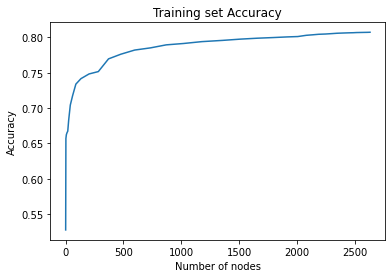

In [16]:
# training set accuracy
root.indices = train[:,483]
acc = np.zeros((h_depth+1),dtype = 'int')
total = np.zeros((h_depth+1),dtype = 'int')
accuracies = np.zeros((h_depth+1),dtype = 'float')
node_count = np.zeros((h_depth+1),dtype = 'int')

get_accuracy(root)

for i in range (h_depth+1):
    accuracies[i] = float(acc[i])/len(train)

for i in range (1,h_depth+1):
    node_count[i] += node_count[i-1]

print("Training set accuracy:", accuracies[h_depth])
plt.title('Training set Accuracy')
plt.plot(node_count,accuracies)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('/content/drive/My Drive/plot_train.png')
plt.close()

Test set accuracy 0.7902739789532243


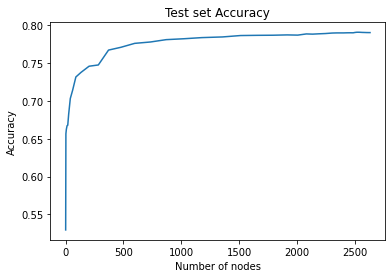

In [18]:
# test set accuracy
acc_test = np.zeros((h_depth+1),dtype = 'int')
total_test = np.zeros((h_depth+1),dtype = 'int')
accuracies_test = np.zeros((h_depth+1),dtype = 'float')
node_count_test = np.zeros((h_depth+1),dtype = 'int')

root.indices = test[:,483]
get_accuracy_test(root)

for i in range (h_depth+1):
    accuracies_test[i] = float(acc_test[i])/len(test)

for i in range (1,h_depth+1):
    node_count_test[i] += node_count_test[i-1]

print("Test set accuracy",accuracies_test[h_depth])

plt.title('Test set Accuracy')
plt.plot(node_count_test,accuracies_test)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('/content/drive/My Drive/plot_test.png',transparent=False,facecolor = 'w',edgecolor = 'w')
plt.close()

Validation set accuracy 0.7971908028926386


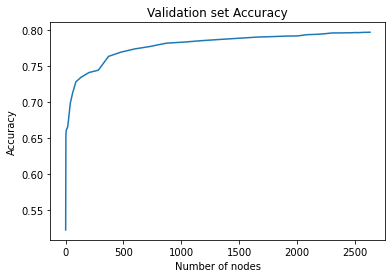

In [17]:
# Validation set accuracy
acc_valid = np.zeros((h_depth+1),dtype = 'int')
total_valid = np.zeros((h_depth+1),dtype = 'int')
accuracies_valid = np.zeros((h_depth+1),dtype = 'float')
node_count_valid = np.zeros((h_depth+1),dtype = 'int')

root.indices = valid[:,483]
get_accuracy_valid(root)

for i in range (h_depth+1):
    accuracies_valid[i] = float(acc_valid[i])/len(valid)

for i in range (1,h_depth+1):
    node_count_valid[i] += node_count_valid[i-1]

print("Validation set accuracy",accuracies_valid[h_depth])

plt.title('Validation set Accuracy')
plt.plot(node_count_valid,accuracies_valid)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('/content/plot_test.png')
plt.close()

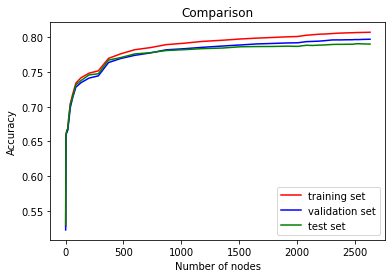

In [19]:
# plot for comaparison
plt.plot(node_count,accuracies,color='red', label='training set')
plt.plot(node_count,accuracies_valid, color='blue', label='validation set')
plt.plot(node_count,accuracies_test, color='green', label='test set')
plt.title('Comparison')
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('/content/plot_comparison.png')
plt.close()

In [20]:
print(node_count_valid)

[   1    3    7   13   19   27   41   61   89  133  203  283  371  477
  597  733  869 1019 1177 1355 1511 1655 1791 1913 2005 2079 2133 2185
 2243 2301 2343 2377 2401 2429 2457 2483 2499 2515 2527 2541 2561 2583
 2601 2621 2629 2629 2629 2629 2629 2629 2629 2629 2629]
